# Import Libraries


In [1]:
import numpy as np
import pandas as pd

from seglearn.pipe import Pype
from seglearn.transform import Interp, Segment, patch_sampler, FeatureRep
from seglearn.feature_functions import base_features, all_features, hudgins_features, emg_features
from seglearn.datasets import load_watch

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, GroupKFold, cross_validate
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


import matplotlib.pyplot as plt

import random
import itertools

from joblib import dump, load
#%matplotlib notebook

# Importand paths

In [2]:
graphs_path = "./Graphs/"

# Importing the Data

In [3]:
FB_data_path = "./Data/Fanis_Balaskas/accel_gyro.csv"
GV_data_path = "./Data/George_Vardakas/accel_gyro_Geo.csv"
ΤT_data_path = "./Data/George_Vardakas/accel_gyro_Ted.csv"
GP_data_path = "./Data/George_Vardakas/accel_gyro_Gregory.csv"
BRO_data_path = "./Data/George_Vardakas/accel_gyro_Bro.csv"
VD_data_path = "./Data/Vagelis_Dimoulis/accel_gyro.csv"
EUH_data_path = "./Data/George_Vardakas/accel_gyro_Euh.csv"

df_FB_accel_gyro = pd.read_csv(FB_data_path)
df_GV_accel_gyro = pd.read_csv(GV_data_path)
df_TT_accel_gyro = pd.read_csv(ΤT_data_path)
df_GP_accel_gyro = pd.read_csv(GP_data_path)
df_BRO_accel_gyro = pd.read_csv(BRO_data_path)
df_VD_accel_gyro = pd.read_csv(VD_data_path)
df_EUH_accel_gyro = pd.read_csv(EUH_data_path)


In [4]:
# Den exw ta ms gia na spasw to shma se kathgories
datetime_format = "%Y-%m-%d %H:%M:%S.%f"
df_FB_accel_gyro["TIMESTAMP"] = pd.to_datetime(df_FB_accel_gyro["TIMESTAMP"])#, format=datetime_format)
df_GV_accel_gyro["TIMESTAMP"] = pd.to_datetime(df_GV_accel_gyro["TIMESTAMP"])#, format=datetime_format)
df_TT_accel_gyro["TIMESTAMP"] = pd.to_datetime(df_TT_accel_gyro["TIMESTAMP"])
df_GP_accel_gyro["TIMESTAMP"] = pd.to_datetime(df_GP_accel_gyro["TIMESTAMP"])
df_BRO_accel_gyro["TIMESTAMP"] = pd.to_datetime(df_BRO_accel_gyro["TIMESTAMP"])
df_VD_accel_gyro["TIMESTAMP"] = pd.to_datetime(df_VD_accel_gyro["TIMESTAMP"])
df_EUH_accel_gyro["TIMESTAMP"] = pd.to_datetime(df_EUH_accel_gyro["TIMESTAMP"])

## Find when activity changes

In [5]:
# Sampling frequency of accelerometer and gyroscope (10 Hz)
sampling_frequency = df_FB_accel_gyro.loc[1, "TIMESTAMP"] - df_FB_accel_gyro.loc[0, "TIMESTAMP"]

# Finding the indexs where the samples differ more than sampling frequency
df_FB_activity_cutoff = df_FB_accel_gyro.loc[df_FB_accel_gyro["TIMESTAMP"] - df_FB_accel_gyro["TIMESTAMP"].shift() > sampling_frequency]
df_GV_activity_cutoff = df_GV_accel_gyro.loc[df_GV_accel_gyro["TIMESTAMP"] - df_GV_accel_gyro["TIMESTAMP"].shift() > sampling_frequency]
df_TT_activity_cutoff = df_TT_accel_gyro.loc[df_TT_accel_gyro["TIMESTAMP"] - df_TT_accel_gyro["TIMESTAMP"].shift() > sampling_frequency]
df_GP_activity_cutoff = df_GP_accel_gyro.loc[df_GP_accel_gyro["TIMESTAMP"] - df_GP_accel_gyro["TIMESTAMP"].shift() > sampling_frequency]
df_BRO_activity_cutoff = df_BRO_accel_gyro.loc[df_BRO_accel_gyro["TIMESTAMP"] - df_BRO_accel_gyro["TIMESTAMP"].shift() > sampling_frequency]
df_VD_activity_cutoff = df_VD_accel_gyro.loc[df_VD_accel_gyro["TIMESTAMP"] - df_VD_accel_gyro["TIMESTAMP"].shift() > sampling_frequency]

df_EUH_activity_cutoff = df_EUH_accel_gyro.loc[df_EUH_accel_gyro["TIMESTAMP"] - df_EUH_accel_gyro["TIMESTAMP"].shift() > sampling_frequency]

In [6]:
#ax = df_GV_accel_gyro[["ACTIVITY_ID", "ACCEL_X", "ACCEL_Y", "ACCEL_Z"]].plot(figsize = (15, 8))
#ax.vlines(df_GV_activity_cutoff.index, ymin=-20, ymax=120)

In [7]:
#ax = df_FB_accel_gyro[["ACTIVITY_ID", "ACCEL_X", "ACCEL_Y", "ACCEL_Z"]].plot(figsize = (15, 8))
#ax.vlines(df_FB_activity_cutoff.index, ymin=-20, ymax=120)

In [8]:
#ax = df_VD_accel_gyro[["ACTIVITY_ID", "ACCEL_X", "ACCEL_Y", "ACCEL_Z"]].plot(figsize = (15, 8))
#ax.vlines(df_VD_activity_cutoff.index, ymin=-20, ymax=120)

In [9]:
#ax = df_TT_accel_gyro[["ACTIVITY_ID", "ACCEL_X", "ACCEL_Y", "ACCEL_Z"]].plot(figsize = (15, 8))
#ax.vlines(df_TT_activity_cutoff.index, ymin=-20, ymax=120)

In [10]:
#ax = df_GP_accel_gyro[["ACTIVITY_ID", "ACCEL_X", "ACCEL_Y", "ACCEL_Z"]].plot(figsize = (15, 8))
#ax.vlines(df_GP_activity_cutoff.index, ymin=-20, ymax=120)

In [11]:
#ax = df_BRO_accel_gyro[["ACTIVITY_ID", "ACCEL_X", "ACCEL_Y", "ACCEL_Z"]].plot(figsize = (15, 8))
#ax.vlines(df_BRO_activity_cutoff.index, ymin=-20, ymax=120)

In [12]:
#ax = df_EUH_accel_gyro[["ACTIVITY_ID", "ACCEL_X", "ACCEL_Y", "ACCEL_Z"]].plot(figsize = (15, 8))
#ax.vlines(df_EUH_activity_cutoff.index, ymin=-20, ymax=120)

## Making one dataframe for all users

In [13]:
df_FB_accel_gyro["USER_ID"] = 0
df_GV_accel_gyro["USER_ID"] = 1
df_VD_accel_gyro["USER_ID"] = 2
df_TT_accel_gyro["USER_ID"] = 3
df_GP_accel_gyro["USER_ID"] = 4
df_BRO_accel_gyro["USER_ID"] = 5
df_EUH_accel_gyro["USER_ID"] = 6

In [14]:
df_accel_gyro = df_FB_accel_gyro.append(df_GV_accel_gyro)
df_accel_gyro = df_accel_gyro.append(df_VD_accel_gyro)
df_accel_gyro = df_accel_gyro.append(df_TT_accel_gyro)
df_accel_gyro = df_accel_gyro.append(df_GP_accel_gyro)
df_accel_gyro = df_accel_gyro.append(df_BRO_accel_gyro)
df_accel_gyro = df_accel_gyro.append(df_EUH_accel_gyro)
df_accel_gyro.reset_index(inplace=True)
del df_FB_accel_gyro, df_GV_accel_gyro, df_VD_accel_gyro, df_TT_accel_gyro, df_GP_accel_gyro, df_EUH_accel_gyro

In [15]:
sampling_frequency = df_accel_gyro.loc[1, "TIMESTAMP"] - df_accel_gyro.loc[0, "TIMESTAMP"]
# Finding the indexs where the samples differ more than sampling frequency
activities = df_accel_gyro.loc[df_accel_gyro['TIMESTAMP'] - df_accel_gyro['TIMESTAMP'].shift() > sampling_frequency]
# To include the last activity to the end
activities = activities.append(df_accel_gyro.iloc[-1])

# Constracting the data exactly how the seglearn needs it
# Data must be list(np.arrays)
# list() -> single multivariate time series
# X[0].shape -> (n_samples, n_variables)
# n_samples is how many data points we have in time we have
# n_variables is how many sensors we have

# I do not include the moment where activity changes
X = list()
y = list()
groups = list()
low_index = 0

# Use this to throw some samples or not?
samples_to_throw = 10

for i, high_index in enumerate(activities.index):
    low_index += samples_to_throw
    high_index -= samples_to_throw
    data = df_accel_gyro[["ACCEL_X","ACCEL_Y", "ACCEL_Z", "GYRO_X", "GYRO_Y", "GYRO_Z"]].iloc[low_index : high_index]
    data = data.to_numpy()
    labels = df_accel_gyro["ACTIVITY_ID"].iloc[low_index]
    user_id = df_accel_gyro["USER_ID"].iloc[low_index]
    
    X.append(data)
    y.append(labels)
    groups.append(user_id)
    
    #print(low_index, mid_index, high_index)
    low_index = high_index

In [16]:
#ax = df_accel_gyro[["ACCEL_X","ACCEL_Y", "ACCEL_Z", "GYRO_X", "GYRO_Y", "GYRO_Z", "ACTIVITY_ID", "USER_ID"]].plot(figsize=(15,8))
#ax.vlines(activities.index, ymin=-20, ymax=120)

In [17]:
#df_accel_gyro.iloc[-1]

## Loading data from other dataset

In [18]:
#data = load_watch()
#X = data['X']
#y = data['y']
#groups = data["subject"]

# Defining the features and the pipeline

In [19]:
class poly(BaseEstimator, TransformerMixin):
    def __init__(self, degree=2):
        self.poly_features = PolynomialFeatures(degree)
    
    def fit(self, Xt, y):
        Xt_new = [self.poly_features.fit_transform(timeseries) for timeseries in Xt[0]]
        Xt_new = np.array(Xt_new)
        #self.Xt = [Xt_new, Xt[1], Xt[2]]
        self.Xt = [Xt_new, Xt[1]]
        return self
            
    def transform(self, Xt, y):
        return self.Xt
    
    def fit_transform(self, Xt, y):
        self.fit(Xt, y)
        return self.transform(self, Xt, y)

def poly_features(Xt):
    poly_features = PolynomialFeatures(2)
    #return poly_features.fit_transform(X)
    
    Xt_new = [poly_features.fit_transform(timeseries) for timeseries in Xt[0]]
    Xt_new = np.array(Xt_new)
    Xt = [Xt_new, Xt[1], Xt[2]]
   
    return Xt

In [20]:
#seg = Segment(width=100, overlap=0.2)
#d = seg.fit_transform(X, y)

In [21]:
#len(d), len(d[0]), len(d[1]), d[0].shape, d[0][0].shape, d[1].shape, type(d[0])

In [22]:
#d = FunctionTransformer(poly_features).fit_transform(d)

In [23]:
#len(d), len(d[0]), len(d[1]), d[0].shape, d[0][0].shape, d[1].shape, type(d[0])

In [24]:
#f = FeatureRep(features = {**base_features(), **emg_features()})

In [25]:
#d = f.fit_transform(d[0])

In [26]:
#d.shape

In [27]:
df_accel_gyro["ACTIVITY_ID"].value_counts()
sampling_strategy={115 : 300, 104 : 250,102 : 250,107 : 250,101 : 250,103 : 250,106 : 150,105 : 123}

In [28]:
sampling_frequency = 10.
def add_period(X):
    """
    I am adding in a column to represent time (10 Hz sampling), since my data doesn't include it
    the Interp class assumes time is the first column in the series.
    """
    return np.array([np.column_stack([np.arange(len(X[i])) / sampling_frequency, X[i]]) for i in np.arange(len(X))])

In [29]:
pipeline = Pype([
    ("timer", FunctionTransformer(add_period)),
    ("interp", Interp(sample_period = 1. / sampling_frequency, categorical_target=True)),
    ("segment", Segment(overlap=0.2, shuffle=True)),
    #("resampler", patch_sampler(RandomUnderSampler)(sampling_strategy="all")),
    
    #("poly_features", FunctionTransformer(poly_features)),
    #("poly_features", poly()),
    
    ("features", FeatureRep(features = {**base_features(), **emg_features()})),
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("rf", RandomForestClassifier(criterion="gini"))
], memory=None)

/home/geo/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass memory=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


## Hyperparameter tuning

In [30]:
splitter = GroupKFold(n_splits=7)
cv = splitter.split(X, y, groups)

parameters_grid = {"interp__sample_period": [0.2], # 0.1
                   "segment__width": [50],
                   "pca__n_components" : [40],
                   "rf__n_estimators": [20],
                   "rf__min_samples_split": [7]
                  }


# scoring does not work for some reason
# it maybe always say the big category for each fragment
# scoring="accuracy", maybe because random forest has out of bag error 
grid_search = GridSearchCV(pipeline, parameters_grid, cv=cv, n_jobs=-1)
grid_search.fit(X, y)

print("GridSearchCV best clf score: %.2f" % (grid_search.best_score_))
print(grid_search.best_estimator_)

/home/geo/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass memory=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
<ipython-input-28-2dfe244e3a25>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([np.column_stack([np.arange(len(X[i])) / sampling_frequency, X[i]]) for i in np.arange(len(X))])
/home/geo/.local/lib/python3.8/site-packages/seglearn/transform.py:237: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify

GridSearchCV best clf score: 0.62
Pype(steps=[('timer',
             FunctionTransformer(func=<function add_period at 0x7f89a84dc550>)),
            ('interp', Interp(categorical_target=True, sample_period=0.2)),
            ('segment', Segment(overlap=0.2, shuffle=True, width=50)),
            ('features',
             FeatureRep(features={'abs_energy': <function abs_energy at 0x7f89b08e01f0>,
                                  'emg_var': <function emg_var at 0x7f89b08de160>,
                                  'integrated_emg': <func...
                                  'std': <function std at 0x7f89b08e0280>,
                                  'var': <function var at 0x7f89b08e0310>,
                                  'waveform_length': <function waveform_length at 0x7f89b08e0c10>,
                                  'willison_amplitude': willison_amplitude(threshold=0),
                                  'zero_crossings': zero_crossing(threshold=0)})),
            ('scaler', StandardScaler

## Cross validation on the best model

In [31]:
best_estimator = grid_search.best_estimator_

cv = splitter.split(X, y, groups)
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
cv_scores = cross_validate(best_estimator, X, y, cv=cv, n_jobs=-1)

cv_scores_df = pd.DataFrame(cv_scores)
cv_scores_df["test_score"]

/home/geo/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass memory=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0    0.711986
1    0.597484
2    0.507985
3    0.662112
4    0.449367
5    0.761124
6    0.628328
Name: test_score, dtype: float64

In [32]:
def plot_confusion_matrix(cm, classes, fold, normalize=True, cmap=plt.cm.Blues):
    title = "Confusion matrix " + str(fold)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize = (15, 8))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.title(title, fontsize=15)
    plt.ylabel("True label", fontsize=15)
    plt.xlabel("Predicted label", fontsize=15)
    plt.tight_layout()
    plt.savefig(graphs_path + title, facecolor = "#E0E0E0")
    plt.show()

## Creating the confusion matrix for each fold

/home/geo/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<ipython-input-28-2dfe244e3a25>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([np.column_stack([np.arange(len(X[i])) / sampling_frequency, X[i]]) for i in np.arange(len(X))])
/home/geo/.local/lib/python3.8/site-packages/seglearn/transform.py:237: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nd

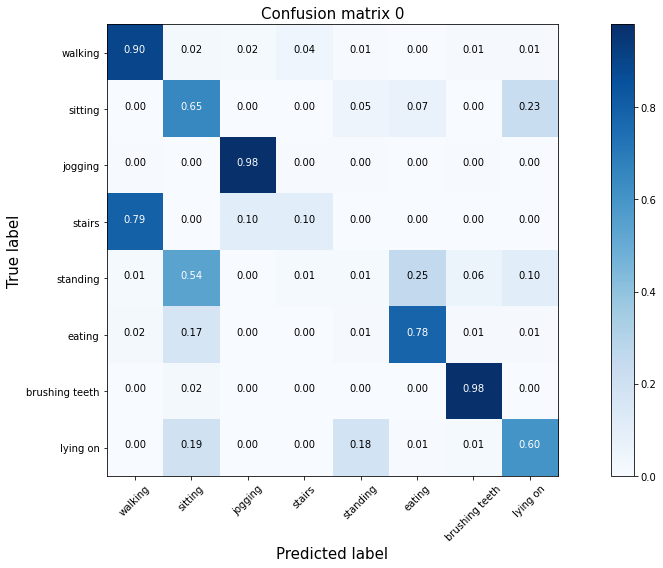

0.7227191413237924
[[177   4   3   8   1   0   2   2]
 [  0 211   0   0  15  22   1  74]
 [  1   0 197   1   1   0   1   0]
 [ 23   0   3   3   0   0   0   0]
 [  1  36   0   1   1  17   4   7]
 [  2  17   0   0   1  80   1   1]
 [  0   1   0   0   0   0  49   0]
 [  0  29   0   0  27   1   2  90]]


/home/geo/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<ipython-input-28-2dfe244e3a25>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([np.column_stack([np.arange(len(X[i])) / sampling_frequency, X[i]]) for i in np.arange(len(X))])
/home/geo/.local/lib/python3.8/site-packages/seglearn/transform.py:237: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nd

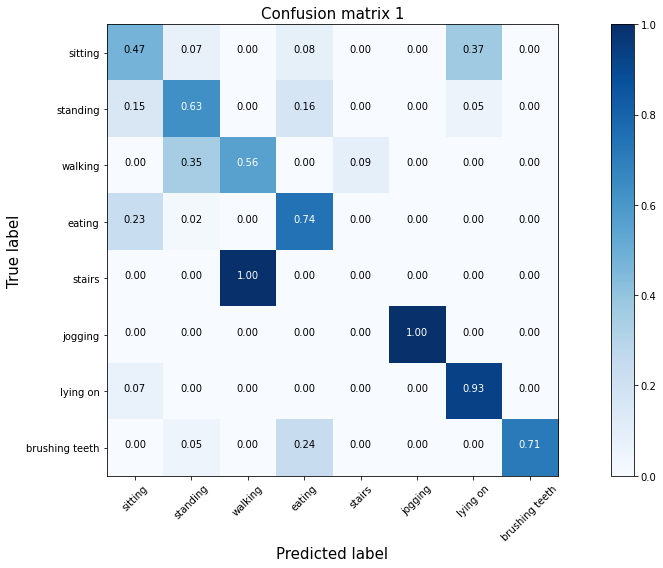

0.6163522012578616
[[45  7  0  8  0  0 35  0]
 [11 46  0 12  0  0  4  0]
 [ 0 15 24  0  4  0  0  0]
 [10  1  0 32  0  0  0  0]
 [ 0  0  7  0  0  0  0  0]
 [ 0  0  0  0  0  7  0  0]
 [ 2  0  0  0  0  0 27  0]
 [ 0  1  0  5  0  0  0 15]]


/home/geo/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<ipython-input-28-2dfe244e3a25>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([np.column_stack([np.arange(len(X[i])) / sampling_frequency, X[i]]) for i in np.arange(len(X))])
/home/geo/.local/lib/python3.8/site-packages/seglearn/transform.py:237: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nd

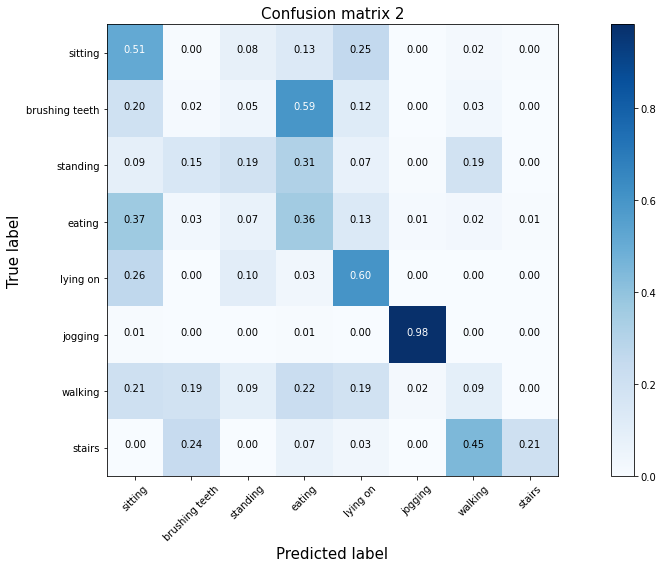

0.5171102661596958
[[121   1  19  31  60   0   4   1]
 [ 13   1   3  39   8   0   2   0]
 [ 18  32  39  65  15   1  39   0]
 [ 60   5  11  58  22   2   4   1]
 [ 31   0  12   4  71   0   0   0]
 [  2   1   0   2   1 374   1   0]
 [ 23  21  10  25  21   2  10   0]
 [  0   7   0   2   1   0  13   6]]


/home/geo/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<ipython-input-28-2dfe244e3a25>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([np.column_stack([np.arange(len(X[i])) / sampling_frequency, X[i]]) for i in np.arange(len(X))])
/home/geo/.local/lib/python3.8/site-packages/seglearn/transform.py:237: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nd

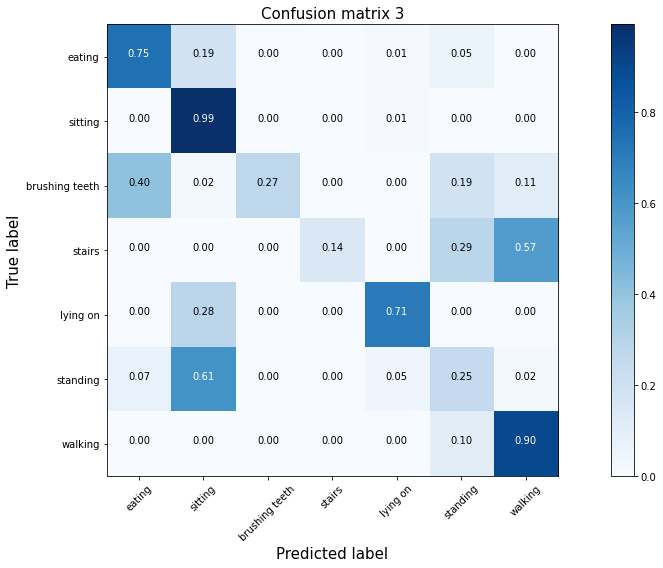

0.6900621118012422
[[155  39   1   0   2  11   0]
 [  0 125   0   0   1   0   0]
 [ 50   2  34   0   0  24  14]
 [  0   0   0   1   0   2   4]
 [  5 301   2   0 759   4   1]
 [  3  27   0   0   2  11   1]
 [  0   0   0   0   0   3  26]]


/home/geo/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<ipython-input-28-2dfe244e3a25>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([np.column_stack([np.arange(len(X[i])) / sampling_frequency, X[i]]) for i in np.arange(len(X))])
/home/geo/.local/lib/python3.8/site-packages/seglearn/transform.py:237: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nd

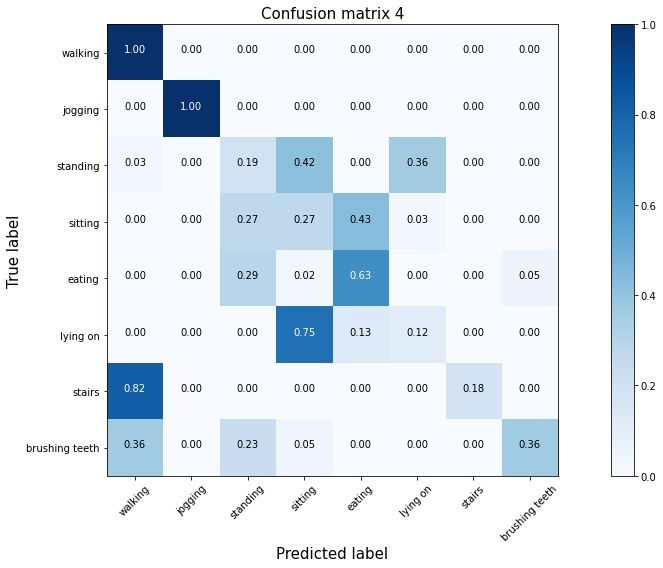

0.4810126582278481
[[36  0  0  0  0  0  0  0]
 [ 0 29  0  0  0  0  0  0]
 [ 1  0  7 15  0 13  0  0]
 [ 0  0 10 10 16  1  0  0]
 [ 0  0 24  2 52  0  0  4]
 [ 0  0  0 39  7  6  0  0]
 [18  0  0  0  0  0  4  0]
 [ 8  0  5  1  0  0  0  8]]


/home/geo/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<ipython-input-28-2dfe244e3a25>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([np.column_stack([np.arange(len(X[i])) / sampling_frequency, X[i]]) for i in np.arange(len(X))])
/home/geo/.local/lib/python3.8/site-packages/seglearn/transform.py:237: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nd

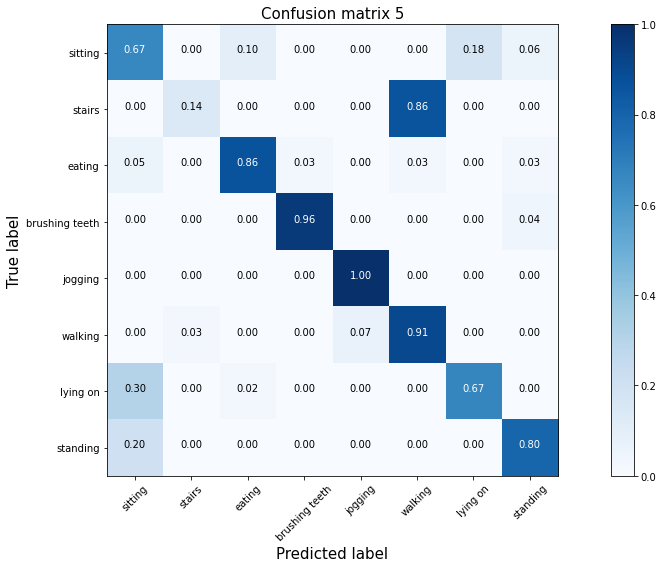

0.7845433255269321
[[34  0  5  0  0  0  9  3]
 [ 0  4  0  0  0 25  0  0]
 [ 2  0 32  1  0  1  0  1]
 [ 0  0  0 49  0  0  0  2]
 [ 0  0  0  0 59  0  0  0]
 [ 0  2  0  0  5 67  0  0]
 [25  0  2  0  0  0 55  0]
 [ 9  0  0  0  0  0  0 35]]


/home/geo/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<ipython-input-28-2dfe244e3a25>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([np.column_stack([np.arange(len(X[i])) / sampling_frequency, X[i]]) for i in np.arange(len(X))])
/home/geo/.local/lib/python3.8/site-packages/seglearn/transform.py:237: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nd

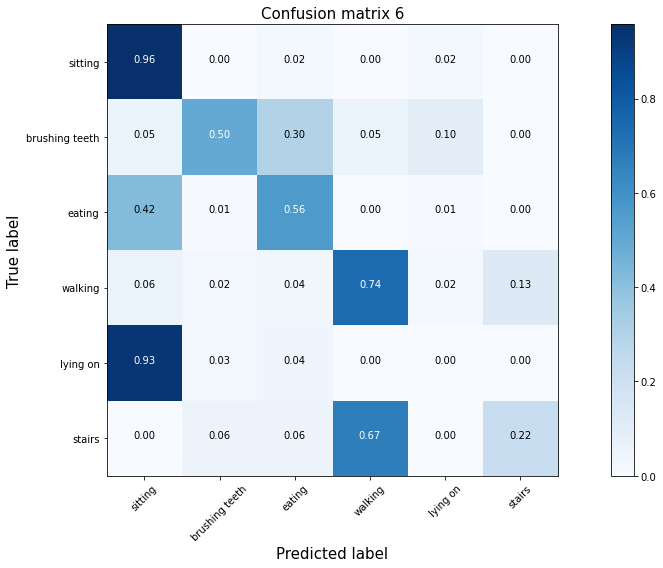

0.6347177848775293
[[226   0   5   0   5   0]
 [  1  10   6   1   2   0]
 [ 47   1  63   0   1   0]
 [ 25   9  14 293   7  50]
 [ 71   2   3   0   0   0]
 [  0   1   1  12   0   4]]


In [33]:
df_activities = pd.read_csv("./Data/HomoreDataFromVariousActivities/activities.csv")

cv = splitter.split(X, y, groups)
for fold, split in enumerate(cv):
    training_set, test_set = split
    
    # Spliting the to training and testing set
    X_train, X_test = np.asarray(X)[training_set], np.asarray(X)[test_set]
    y_train, y_test = np.asarray(y)[training_set], np.asarray(y)[test_set]
    
    visited = dict()
    labels = list()
    for yi_label in y_test:
        if yi_label not in visited:
            visited[yi_label] = True
            labels.append(yi_label)

    # Fiting the model
    best_estimator = best_estimator.fit(X_train, y_train)
    
    # Predicting with trained model
    # Transform_predict generates true and predicted target values for the segments
    y_true, y_pred = best_estimator.transform_predict(X_test, y_test)
    
    # Printing accuracy score and confusion matrix
    confusion_mat = confusion_matrix(y_true, y_pred, labels=labels)
    #confusion_mat = confusion_matrix(y_true, y_pred)
    clf_accuracy = accuracy_score(y_true, y_pred)
    
    # Select the right labels and order them correcly
    labels_names = df_activities.loc[df_activities["ACTIVITY_ID"].isin(labels)]
    labels_names = labels_names.iloc[pd.Categorical(labels_names["ACTIVITY_ID"], categories = labels, ordered=True).argsort()]
    labels_names = labels_names["NAME"].to_list()
    plot_confusion_matrix(confusion_mat, labels_names, fold, normalize=True)
    
    print(clf_accuracy)
    print(confusion_mat)
    

# Dump and Load the model

In [34]:
# Dump the model
best_estimator = best_estimator.fit(X, y)
model_path = './Model/classifier.joblib'
dump(best_estimator, model_path) 

<ipython-input-28-2dfe244e3a25>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([np.column_stack([np.arange(len(X[i])) / sampling_frequency, X[i]]) for i in np.arange(len(X))])
/home/geo/.local/lib/python3.8/site-packages/seglearn/transform.py:237: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Xt = np.array([sliding_tensor(Xt[i], self.width, self._step, self.order)


['./Model/classifier.joblib']

In [35]:
# Load the model
clf = load(model_path)
dummy_data = np.random.rand(150, 6)
dummy_data = [dummy_data]
pred = clf.predict(dummy_data)
pred

array([115])

In [36]:
df_accel_gyro

,index,TIMESTAMP,ACCEL_X,ACCEL_Y,ACCEL_Z,GYRO_X,GYRO_Y,GYRO_Z,ACTIVITY_ID,USER_ID
0,0,2020-08-25 16:23:14.590,-1.230657,5.430215,7.670058,-1.084472,0.181100,-0.076701,107,0
1,1,2020-08-25 16:23:14.690,-1.743032,4.716721,8.117788,-1.465848,0.301478,-0.136357,107,0
2,2,2020-08-25 16:23:14.790,-2.229070,4.455745,8.960572,-1.877052,0.394159,-0.137423,107,0
3,3,2020-08-25 16:23:14.890,-2.496031,3.766193,9.097046,-1.774784,0.359005,-0.070309,107,0
4,4,2020-08-25 16:23:14.990,-2.711515,2.225478,9.026415,-2.076263,0.344090,-0.100138,107,0
...,...,...,...,...,...,...,...,...,...,...
489595,25795,2021-03-07 16:27:34.281,-2.233858,-6.383136,9.694418,8.220896,-4.834317,1.776915,106,6
489596,25796,2021-03-07 16:27:34.381,-1.625712,0.611736,11.438647,2.172140,-2.306367,2.551386,106,6
489597,25797,2021-03-07 16:27:34.481,-1.426988,3.131711,7.817307,0.971550,-1.068492,1.793960,106,6
489598,25798,2021-03-07 16:27:34.581,0.022745,5.057905,8.141730,-0.002131,-0.062852,0.778731,106,6


In [37]:
data = df_accel_gyro[["ACCEL_X", "ACCEL_Y", "ACCEL_Z", "GYRO_X", "GYRO_Y", "GYRO_Z"]].iloc[460799 - 1000:460799]
data = [data.to_numpy()]

In [38]:
clf.predict(data)

array([115, 104, 103, 103, 103, 103, 103, 115, 115, 103, 103, 115])

In [39]:
data[0].shape

(1000, 6)